<html>
   <head>
      <title>Clustering</title>
   </head>
   <body>
      <h1><font size="6">Part 3: Clustering</font></h1>
      <p><font size="3">This Notebook consists of the Custering of the Customers from the data set with the goal of getting individual scores and segments for them. At first I take a look at the necessity of scaling this particular set of data. Afterwards the customers are clustered with the RFM method.</font></p>
      <ul style="list-style-type:none;line-height: 2;">
         <li><font size="3"><a href='#1'>1. Clustering of User Data</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#1.1'>1.1 Preparation for Kmeans</a></font></li>
             <li><font size="3"><a href='#1.2'>1.2 Elbow Method</a></font></li>
             <li><font size="3"><a href='#1.3'>1.3 Score Function</a></font></li>
             <li><font size="3"><a href='#1.4'>1.4 Clustering and Evalutation</a></font></li>
                 <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
                 <li><font size="3"><a href='#1.4.1'>1.4.1 Unscaled</a></font></li>
                 <li><font size="3"><a href='#1.4.2'>1.4.2 Standard Scaled</a></font></li>
                 <li><font size="3"><a href='#1.4.3'>1.4.3 MinMax Scaled</a></font></li>
                 </ul> 
             </ul>          
         <li><font size="3"><a href='#2'>2. Segmenting Customers by RFM</a></font></li>
             <ul style="margin-left: 1em; padding-left: 1em;list-style-type:none">
             <li><font size="3"><a href='#2.1'>2.1 Recency</a></font></li>
             <li><font size="3"><a href='#2.2'>2.2 Frequency</a></font></li>
             <li><font size="3"><a href='#2.3'>2.3 Monetary Value</a></font></li>
             <li><font size="3"><a href='#2.4'>2.4 Overall User Score</a></font></li>
             </ul>          
      </ul>
   </body>
</html>

## Importing libraries

In [1]:
# Importing the necessary libraries
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import datetime
from operator import itemgetter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.mixture import GaussianMixture

## Setting options

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

## Loading Dataframes

In [3]:
df = pd.read_pickle("./Data/dataframefull.pickle")
df_user = pd.read_pickle("./Data/users.pickle")
df_month = pd.read_pickle("./Data/months.pickle")

In [4]:
df_user_std = df_user.copy()
df_user_mm = df_user.copy()

In [5]:
df_user.head()

,user_id,revenue,women_article,men_article,kids_article,homeandliving_article,avg_shop_cart,total_purchases,avg_cart_itemcount,monday,times_bought_monday,tuesday,times_bought_tuesday,wednesday,times_bought_wednesday,thursday,times_bought_thursday,friday,times_bought_friday,saturday,times_bought_saturday,sunday,times_bought_sunday,user_type,country,region,city,device_category,device_browser,device_os,country_slim
0,1,147.01,6,1,0,0,73.505,2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,first,Germany,Lower Saxony,Varel,desktop,Firefox,Windows,Germany
1,2,208.34,8,0,0,0,208.340,1,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,first,Germany,Mecklenburg-Vorpommern,Stralsund,desktop,Internet Explorer,Windows,Germany
2,3,84.11,0,1,0,0,84.110,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Lower Saxony,Buchholz in der Nordheide,tablet,Safari,iOS,Germany
3,4,62.32,1,4,0,0,62.320,1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Berlin,Berlin,desktop,Chrome,Windows,Germany
4,5,89.89,0,0,4,0,44.945,2,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,first,Germany,Schleswig-Holstein,Neumunster,tablet,Safari,iOS,Germany


In [6]:
df_month.head()

,year_month,revenue,monthly_growth_revenue,avg_shop_cart,avg_cart_itemcount,active_customers,total_purchases,women_article,men_article,kids_article,homeandliving_article,revenue_first,revenue_established,first_user_count,established_user_count,retained_user_count,retention_rate,ratio_first_to_established
0,201711,5.268517e+06,0.000000,103.495016,3.466743,46985,50906,96910,61491,14107,999,5.268517e+06,0.00,46985,0,46985,1.000000,0.000000
1,201712,4.983451e+06,-0.054108,90.652698,3.284649,50004,54973,95202,64962,15461,1806,4.619641e+06,363809.47,46799,3205,3205,0.064095,14.601872
2,201801,3.717325e+06,-0.254066,87.034361,3.661563,38221,42711,89365,52416,10983,1100,3.216473e+06,500851.97,33596,4625,3141,0.082180,7.264000
3,201802,3.056483e+06,-0.177773,90.680675,3.791995,30837,33706,67535,42438,14910,795,2.526812e+06,529670.62,26114,4723,2520,0.081720,5.529113
4,201803,6.210612e+06,1.031947,108.247849,3.966274,52209,57374,139458,66852,18202,964,5.122223e+06,1088389.01,44512,7697,2797,0.053573,5.783032


<a id='1'></a>

# 1. Clustering of User Data

<a id='1.1'></a>

## 1.1 Preparation for Kmeans (dummies and scaling)

In [7]:
user_dum = pd.get_dummies(df_user.drop(columns=["user_id", "region", "city","country"]))
#region and city need to be dropped as the computing power 
#needed get the dummies for them exceeds what I have at my disposal.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_scale_std = scaler.fit_transform(user_dum)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
user_scale_mm = scaler.fit_transform(user_dum)

<a id='1.2'></a>

## 1.2 Elbow method 

In [10]:
#function to get the name of a dataframe (for plotting reasons)
def get_df_name(df):
    name = [x for x in globals() if globals()[x] is df][0]
    return name

In [11]:
#function to plot the elbow graph for one to nine clusters
def elbow(data):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_jobs=-1).fit(data)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("Elbow plot for {}".format(get_df_name(data)))
    plt.xlabel("Number of cluster")
    plt.show()

In [12]:
#function to plot the elbow graph for one to nine clusters and save the clusters in the dataframe
def elbow_withsave(data):
    sse={}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000, n_jobs=-1).fit(data)
        data["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.title("Elbow plot for {}".format(get_df_name(data)))
    plt.xlabel("Number of cluster")
    plt.show()

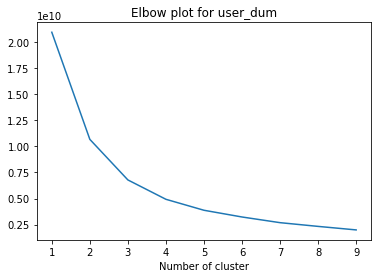

In [13]:
#elbow for unscaled data
elbow(user_dum)

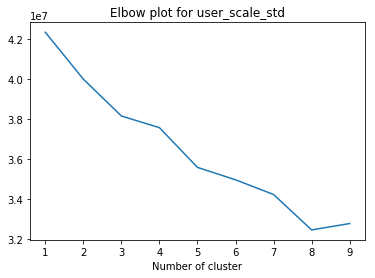

In [14]:
#elbow for standard scaler
elbow(user_scale_std)

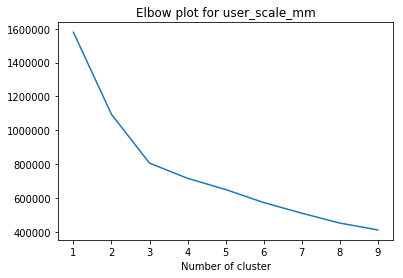

In [15]:
#elbow for minmax scaler
elbow(user_scale_mm)

<a id='1.3'></a>

## 1.3 Score Function

In [13]:
#plot multiple scores for kmeans of specific data
def getscores(data):
    km_scores = []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
    for i in range(2,10):
        km = KMeans(n_clusters=i, random_state=0, n_jobs=-1).fit(data)
        preds = km.predict(data)
    
        print("Score for number of cluster(s) {}: {}".format(i,km.score(data)))
        km_scores.append(-km.score(data))
    
        #silhouette = silhouette_score(data,preds)
        #km_silhouette.append(silhouette)
        #print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
        
        #Silhouette score is commented out as it needs too much computation power and time
    
        db = davies_bouldin_score(data,preds)
        db_score.append(db)
        print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
        #v_measure = v_measure_score(y,preds)
        #vmeasure_score.append(v_measure)
        #print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
        #print("-"*100)
        
        #same as for Silhouette above

    plt.figure(figsize=(7,4))
    plt.title("The elbow method for determining number of clusters\n",fontsize=16)
    plt.scatter(x=[i for i in range(2,10)],y=km_scores,s=150,edgecolor='k')
    plt.grid(True)
    plt.xlabel("Number of clusters",fontsize=14)
    plt.ylabel("K-means score",fontsize=15)
    plt.xticks([i for i in range(2,12)],fontsize=14)
    plt.yticks(fontsize=15)
    plt.show()
    
    plt.figure(figsize=(7,4))
    plt.scatter(x=[i for i in range(2,10)],y=db_score,s=150,edgecolor='k')
    plt.grid(True)
    plt.xlabel("Davies-Bouldin score")
    plt.show()        

<a id='1.4'></a>

## 1.4 Clustering and Evaluation

In [14]:
#function to order the clusters produced by the ML 
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final



<a id='1.4.1'></a>

## 1.4.1 Unscaled

In [15]:
kmeans = KMeans(n_clusters=4, max_iter=1000, n_jobs=-1)
kmeans.fit(user_dum)
df_user['cluster'] = kmeans.predict(user_dum)

In [16]:
df_user_wcluster = order_cluster('cluster', 'revenue',df_user,True)

In [17]:
df_user_wcluster.groupby('cluster').describe()

user_id                                                            \
            count           mean            std    min        25%       50%   
cluster                                                                       
0        426333.0  311436.231913  179834.685790    1.0  155739.00  311403.0   
1        154198.0  311303.903105  179493.843840    2.0  155773.75  311585.5   
2         38733.0  310038.729197  179747.691990   22.0  153815.00  309508.0   
3          3353.0  310162.448852  177923.970671  121.0  162373.00  306391.0   

                               revenue                                   \
               75%       max     count         mean         std     min   
cluster                                                                   
0        467365.00  622618.0  426333.0    61.645607   32.464433    0.00   
1        466325.75  622606.0  154198.0   203.874821   60.576532  122.65   
2        465366.00  622613.0   38733.0   491.796986  145.270898  311.81   
3        461138.00  622509.0    3353.0  1417.785652  659.666064  942.84   

                                             women_article             \
             25%      50%      75%       max         count       mean   
cluster                                                                 
0          33.61    55.45    84.02    195.25      426333.0   1.336028   
1         153.75   191.56   243.67    410.99      154198.0   4.302890   
2         383.47   452.42   562.92   1001.06       38733.0  10.663853   
3        1056.88  1222.32  1544.99  21205.01        3353.0  36.270504   

                                                 men_article             \
               std  min   25%   50%   75%    max       count       mean   
cluster                                                                   
0         1.572600  0.0   0.0   1.0   2.0   20.0    426333.0   1.001886   
1         3.743652  0.0   1.0   4.0   7.0   34.0    154198.0   2.396477   
2         8.021911  0.0   4.0  10.0  15.0   67.0     38733.0   4.993442   
3        25.065461  0.0  23.0  33.0  46.0  532.0      3353.0  11.495079   

                                               kids_article            \
               std  min  25%  50%   75%    max        count      mean   
cluster                                                                 
0         1.654009  0.0  0.0  0.0   2.0   27.0     426333.0  0.281376   
1         3.576269  0.0  0.0  0.0   4.0   37.0     154198.0  0.512380   
2         6.821132  0.0  0.0  2.0   8.0   76.0      38733.0  0.997754   
3        16.231527  0.0  1.0  5.0  16.0  209.0       3353.0  2.676707   

                                             homeandliving_article            \
              std  min  25%  50%  75%    max                 count      mean   
cluster                                                                        
0        1.172255  0.0  0.0  0.0  0.0   37.0              426333.0  0.020740   
1        2.115521  0.0  0.0  0.0  0.0   44.0              154198.0  0.028094   
2        3.536749  0.0  0.0  0.0  0.0   85.0               38733.0  0.049389   
3        7.362169  0.0  0.0  0.0  1.0  125.0                3353.0  0.188488   

                                            avg_shop_cart              \
              std  min  25%  50%  75%   max         count        mean   
cluster                                                                 
0        0.197530  0.0  0.0  0.0  0.0  10.0      426333.0   56.260625   
1        0.302139  0.0  0.0  0.0  0.0  13.0      154198.0  162.351067   
2        0.444147  0.0  0.0  0.0  0.0  20.0       38733.0  270.474352   
3        1.005782  0.0  0.0  0.0  0.0  19.0        3353.0  212.035179   

                                                                      \
                std        min         25%     50%      75%      max   
cluster                                                                
0         28.188615   0.000000   33.610000   50.41   75.610   122.76   
1         58.815010

In [18]:
df_user_wcluster.groupby(["cluster"]).agg({
    "revenue": ["count", "mean", "sum"],
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": "mean",
    #"user_type": "mode"  
})#.round(0)

revenue                            women_article men_article  \
          count         mean           sum           sum         sum   
cluster                                                                
0        426333    61.645607  2.628156e+07        569593      427137   
1        154198   203.874821  3.143709e+07        663497      369532   
2         38733   491.796986  1.904877e+07        413043      193411   
3          3353  1417.785652  4.753835e+06        121615       38543   

        kids_article homeandliving_article avg_shop_cart total_purchases  \
                 sum                   sum          mean            mean   
cluster                                                                    
0             119960                  8842     56.260625        1.120275   
1              79008                  4332    162.351067        1.465577   
2              38646                  1913    270.474352        2.606124   
3               8975                   632    212.035179        9.097226   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 2.399974  0.135884  0.151328  0.128988  0.162516  0.153708   
1                 5.636193  0.170093  0.192169  0.169451  0.211540  0.191909   
2                 8.683702  0.290037  0.339917  0.288049  0.375261  0.337826   
3                 7.344472  1.000298  1.162541  0.977930  1.337012  1.195944   

         saturday    sunday  
             mean      mean  
cluster                      
0        0.181124  0.199436  
1        0.236164  0.277546  
2        0.436734  0.494307  
3        1.527885  1.617059

As we can see cluster 0 seems to denote those customers who mostly bought once for a low value. They have a share about of 68%.<br>
Cluster 1 have about the same number of purchases but a higher itemcount and value. They have a share of about 25%.<br>
Cluster 2 are the middle ground in terms of purchases and value with a share of 6%.<br>
Cluster 3 includes the power buyers with the highes purchases and values. They only have a share of about 0,5%.

<a id='1.4.2'></a>

## 1.4.2 Standard Scaled

In [22]:
kmeans = KMeans(n_clusters=3, max_iter=1000, n_jobs=-1)
kmeans.fit(user_scale_std)
df_user_std['cluster'] = kmeans.predict(user_scale_std)

In [23]:
ordered_by_rev_std = order_cluster('cluster', 'revenue',df_user_std,False)

In [24]:
ordered_by_rev_std.groupby('cluster').describe()

user_id                                                           \
            count           mean            std   min        25%       50%   
cluster                                                                      
0         82853.0  311272.164894  179302.075633  22.0  156451.00  311109.0   
1        240780.0  311396.534961  179770.296971   1.0  155486.50  311415.5   
2        298984.0  311250.089416  179826.069131   3.0  155599.75  311285.5   

                               revenue                                       \
               75%       max     count        mean         std  min     25%   
cluster                                                                       
0        466085.00  622613.0   82853.0  328.793834  323.208745  0.0  136.93   
1        467073.50  622618.0  240780.0  103.734233   92.514942  0.0   41.97   
2        467117.75  622617.0  298984.0   98.007150   87.575581  0.0   39.30   

                                    women_article                            \
            50%       75%       max         count      mean        std  min   
cluster                                                                       
0        237.77  411.0400  21205.01       82853.0  8.072067  10.168994  0.0   
1         74.78  133.5900   1160.34      240780.0  1.978001   2.785788  0.0   
2         68.20  125.6825    975.48      298984.0  2.082687   2.695167  0.0   

                               men_article                                     \
         25%  50%   75%    max       count      mean       std  min  25%  50%   
cluster                                                                         
0        2.0  5.0  11.0  532.0     82853.0  3.580148  6.257593  0.0  0.0  1.0   
1        0.0  1.0   3.0   36.0    240780.0  1.649635  2.711807  0.0  0.0  0.0   
2        0.0  1.0   3.0   35.0    298984.0  1.119786  2.193875  0.0  0.0  0.0   

                    kids_article                                          \
         75%    max        count      mean       std  min  25%  50%  75%   
cluster                                                                    
0        5.0  209.0      82853.0  0.968812  3.359787  0.0  0.0  0.0  0.0   
1        2.0   50.0     240780.0  0.296021  1.354480  0.0  0.0  0.0  0.0   
2        1.0   35.0     298984.0  0.317890  1.384229  0.0  0.0  0.0  0.0   

               homeandliving_article                                          \
           max                 count      mean       std  min  25%  50%  75%   
cluster                                                                        
0        125.0               82853.0  0.051428  0.430540  0.0  0.0  0.0  0.0   
1         44.0              240780.0  0.022410  0.229710  0.0  0.0  0.0  0.0   
2         37.0              298984.0  0.020275  0.214335  0.0  0.0  0.0  0.0   

              avg_shop_cart                                              \
          max         count        mean        std  min      25%    50%   
cluster                                                                   
0        20.0       82853.0  105.181515  72.756009  0.0  54.3550  85.82   
1        16.0      240780.0   98.554377  85.670580  0.0  40.3300  71.40   
2        12.0      298984.0   92.856744  81.141069  0.0  37.9975  67.21   

                             total_purchases                                \
                75%      max           count      mean       std  min  25%   
cluster                                                                      
0        135.086667  2099.47         82853.0  3.186861  2.450177  1.0  2.0   
1        126.030000  1159.57        240780.0  1.055844  0.252911  1.0  1.0   
2        117.630000   975.48        298984.0  1.059515  0.260923  1.0  1.0   

                         avg_cart_itemcount                                \
         50%  75%    max              count      mean       std  min  25%   
cluster                                                                     
0        2.0  3

In [25]:
df_user_std.groupby(["cluster"]).agg({
    "revenue": ["count", "mean", "sum"],
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue                           women_article men_article  \
          count        mean           sum           sum         sum   
cluster                                                               
0         82853  328.793834  2.724156e+07        668795      296626   
1        240780  103.734233  2.497713e+07        476263      397199   
2        298984   98.007150  2.930257e+07        622690      334798   

        kids_article homeandliving_article avg_shop_cart total_purchases  \
                 sum                   sum          mean            mean   
cluster                                                                    
0              80269                  4261    105.181515        3.186861   
1              71276                  5396     98.554377        1.055844   
2              95044                  6062     92.856744        1.059515   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 4.063804  0.359504  0.421638  0.346783  0.472246  0.413359   
1                 3.779657  0.134712  0.144235  0.127070  0.156321  0.145726   
2                 3.366352  0.122167  0.138967  0.121174  0.147690  0.143426   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.538641  0.588971   82853  
1        0.151321  0.189090  240780  
2        0.182655  0.194204  298984

The standardscaler gives us clusters with less information than the clustering without scaling.

<a id='1.4.3'></a>

## 1.4.3 MinMax Scaled

In [26]:
kmeans = KMeans(n_clusters=3, max_iter=1000, n_jobs=-1)
kmeans.fit(user_scale_mm)
df_user_mm['cluster'] = kmeans.predict(user_scale_mm)

In [27]:
ordered_by_rev_mm = order_cluster('cluster', 'revenue',df_user_mm,False)

In [28]:
ordered_by_rev_mm.groupby('cluster').describe()

user_id                                                          \
            count           mean            std  min        25%       50%   
cluster                                                                     
0        191448.0  311250.576997  179931.743101  6.0  155339.75  311020.5   
1        275426.0  311315.790702  179733.515850  1.0  155456.25  311375.0   
2        155743.0  311371.449535  179494.931621  3.0  156394.00  311523.0   

                               revenue                                      \
               75%       max     count        mean         std  min    25%   
cluster                                                                      
0        467086.25  622616.0  191448.0  132.310932  170.896567  0.0  42.01   
1        466874.75  622618.0  275426.0  131.711485  157.695398  0.0  44.52   
2        466968.00  622617.0  155743.0  127.863360  166.397869  0.0  42.01   

                                 women_article                                \
           50%     75%       max         count      mean       std  min  25%   
cluster                                                                        
0        80.66  157.09   6267.30      191448.0  3.087308  5.250334  0.0  0.0   
1        84.02  159.65   6112.63      275426.0  2.670866  4.678867  0.0  0.0   
2        80.65  152.47  21205.01      155743.0  2.831992  5.004043  0.0  0.0   

                         men_article                                          \
         50%  75%    max       count      mean       std  min  25%  50%  75%   
cluster                                                                        
0        2.0  4.0  282.0    191448.0  1.377920  3.039565  0.0  0.0  0.0  2.0   
1        1.0  3.0  209.0    275426.0  1.989010  3.652601  0.0  0.0  1.0  3.0   
2        1.0  4.0  532.0    155743.0  1.393308  2.941176  0.0  0.0  0.0  2.0   

               kids_article                                                 \
           max        count      mean       std  min  25%  50%  75%    max   
cluster                                                                      
0        195.0     191448.0  0.404825  1.846338  0.0  0.0  0.0  0.0  125.0   
1        209.0     275426.0  0.370967  1.701476  0.0  0.0  0.0  0.0   85.0   
2         84.0     155743.0  0.429631  1.846337  0.0  0.0  0.0  0.0   59.0   

        homeandliving_article                                                \
                        count      mean       std  min  25%  50%  75%   max   
cluster                                                                       
0                    191448.0  0.021896  0.248688  0.0  0.0  0.0  0.0  20.0   
1                    275426.0  0.026497  0.264320  0.0  0.0  0.0  0.0  16.0   
2                    155743.0  0.027154  0.263069  0.0  0.0  0.0  0.0  13.0   

        avg_shop_cart                                                   \
                count       mean        std  min        25%        50%   
cluster                                                                  
0            191448.0  92.637845  78.456486  0.0  39.979808  67.220000   
1            275426.0  99.555538  84.471390  0.0  42.010000  73.925000   
2            155743.0  96.644433  81.572287  0.0  41.170000  71.183333   

                         total_purchases                                     \
            75%      max           count      mean       std  min  25%  50%   
cluster                                                                       
0        117.64   975.48        191448.0  1.412420  1.337955  1.0  1.0  1.0   
1        127.71  2099.47        275426.0  1.316107  1.105581  1.0  1.0  1.0   
2        124.33  1138.39        155743.0  1.297972  1.068799  1.0  1.0  1.0   

                    avg_cart_itemcount                                     \
         75%    max              count      mean       std  min  25%  50%   
cluster                                                                     
0        1.0   55.0  

In [29]:
df_user_mm.groupby(["cluster"]).agg({
    "revenue": ["count", "mean", "sum"],
    "women_article": "sum",
    "men_article": "sum",
    "kids_article": "sum",
    "homeandliving_article": "sum",
    "avg_shop_cart": "mean",
    "total_purchases": "mean",
    "avg_cart_itemcount": "mean",
    "monday": "mean",
    "tuesday": "mean",
    "wednesday": "mean",
    "thursday": "mean",
    "friday": "mean",
    "saturday": "mean",
    "sunday": ["mean", "count"],
    #"user_type": "mode"  
})#.round(0)

revenue                           women_article men_article  \
          count        mean           sum           sum         sum   
cluster                                                               
0        191448  132.310932  2.533066e+07        591059      263800   
1        275426  131.711485  3.627677e+07        735626      547825   
2        155743  127.863360  1.991382e+07        441063      216998   

        kids_article homeandliving_article avg_shop_cart total_purchases  \
                 sum                   sum          mean            mean   
cluster                                                                    
0              77503                  4192     92.637845        1.412420   
1             102174                  7298     99.555538        1.316107   
2              66912                  4229     96.644433        1.297972   

        avg_cart_itemcount    monday   tuesday wednesday  thursday    friday  \
                      mean      mean      mean      mean      mean      mean   
cluster                                                                        
0                 3.393944  0.159108  0.186542  0.159202  0.200039  0.189890   
1                 3.831738  0.164669  0.178051  0.155374  0.195065  0.178981   
2                 3.519423  0.147249  0.169889  0.143082  0.185562  0.170589   

         saturday    sunday          
             mean      mean   count  
cluster                              
0        0.242912  0.255829  191448  
1        0.193802  0.239171  275426  
2        0.229808  0.241032  155743

Completely unrelevant for this usecase.

<a id='2'></a>

# 2. Segmenting Customers by RFM (Recency, Frequency, Monetary Value)

<a id='2.1'></a>

### 2.1 Recency

In [49]:
#create a dataframe to keep user_id and new segmentation scores

#most recent purchase date for each customer
user_scores = df.groupby('user_id').date.max().reset_index()
user_scores.columns = ['user_id','most_recent_purchase']

#we take our observation point as the max invoice date in our dataset
user_scores['recency'] = (user_scores['most_recent_purchase'].max() - user_scores['most_recent_purchase']).dt.days

user_scores.drop(columns="most_recent_purchase", inplace=True)

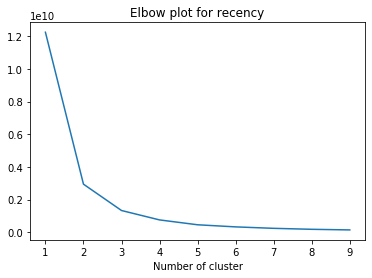

In [20]:
#elbow for recency
recency = user_scores[['recency']]
elbow_withsave(recency)

Score for number of cluster(s) 2: -2941314254.374103
Davies Bouldin score for number of cluster(s) 2: 0.48377750442140827
Score for number of cluster(s) 3: -1328320572.227971
Davies Bouldin score for number of cluster(s) 3: 0.4960468892857106
Score for number of cluster(s) 4: -752106674.4219259
Davies Bouldin score for number of cluster(s) 4: 0.5166396194432336
Score for number of cluster(s) 5: -454385937.98192495
Davies Bouldin score for number of cluster(s) 5: 0.5015157244884145
Score for number of cluster(s) 6: -325077416.7034378
Davies Bouldin score for number of cluster(s) 6: 0.4961412612403427
Score for number of cluster(s) 7: -236640032.835734
Davies Bouldin score for number of cluster(s) 7: 0.4980128747500539
Score for number of cluster(s) 8: -176528511.57197347
Davies Bouldin score for number of cluster(s) 8: 0.4909551698360141
Score for number of cluster(s) 9: -139449196.87129074
Davies Bouldin score for number of cluster(s) 9: 0.4943105978672503


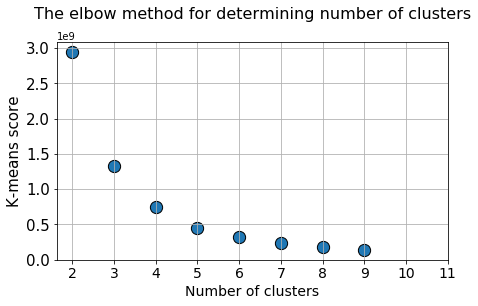

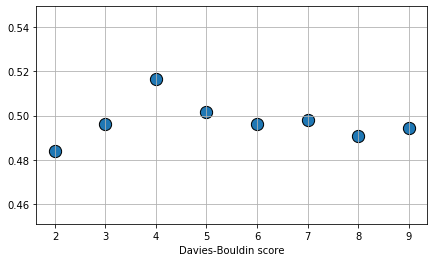

In [13]:
getscores(recency)

In [50]:
#there seems to be the choice between 3 and 4 clusters. Three will be the choice from here on (arbitrarily chosen).
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_scores[['recency']])
user_scores['recency_cluster'] = kmeans.predict(user_scores[['recency']])


user_scores = order_cluster('recency_cluster', 'recency',user_scores,False)

#see details of each cluster
user_scores.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,169451.0,410.295643,45.684057,334.0,368.0,415.0,451.0,484.0
1,188892.0,255.966393,44.850109,173.0,221.0,257.0,293.0,333.0
2,264274.0,88.589963,47.422349,0.0,51.0,93.0,127.0,172.0


<a id='2.2'></a>

### 2.2 Frequency

In [52]:
#get order counts for each user and create a dataframe with it; same as total_purchases in df_user
frequency_purch = df.groupby('user_id')['visit_id'].nunique().reset_index()
frequency_purch.columns = ['user_id','frequency']

#add this data to our main dataframe
user_scores = pd.merge(user_scores, frequency_purch, on='user_id')


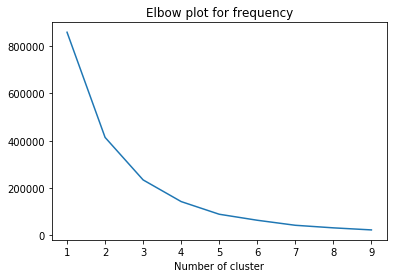

In [35]:
#elbow for frequency
frequency = user_scores[['frequency']]
elbow(frequency)

In [58]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_scores[['frequency']])
user_scores['frequency_cluster'] = kmeans.predict(user_scores[['frequency']])

#order the frequency cluster
user_scores = order_cluster('frequency_cluster', 'frequency',user_scores,True)

#see details of each cluster
user_scores.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,581146.0,1.119991,0.324951,1.0,1.0,1.0,1.0,2.0
1,39656.0,3.974077,1.400122,3.0,3.0,3.0,4.0,9.0
2,1815.0,14.639669,7.247946,10.0,11.0,12.0,16.0,126.0


<a id='2.3'></a>

### 2.3 Monetary Value

In [60]:
#calculate monetary value for each customer
mon_val = df.groupby('user_id').total_price.sum().reset_index()

#merge it with our main dataframe
user_scores = pd.merge(user_scores, mon_val, on='user_id')
user_scores = user_scores.rename(columns={"total_price": "monetary_value"})

In [25]:
#elbow for monetary_value
mon = user_scores[['monetary_value']]
#getscores(mon)
#elbow(mon)

In [63]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(user_scores[['monetary_value']])
user_scores['monetary_value_cluster'] = kmeans.predict(user_scores[['monetary_value']])

#order the monetary value cluster
user_scores = order_cluster('monetary_value_cluster', 'monetary_value',user_scores,True)

#see details of each cluster
user_scores.groupby('monetary_value_cluster')['monetary_value'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_value_cluster,,,,,,,,
0,514857.0,78.608791,48.529573,0.00,38.6500,67.210,109.240,204.35
1,100636.0,329.967489,115.062277,204.36,240.7375,293.815,386.490,715.95
2,7124.0,1100.836554,544.521621,716.13,805.6825,932.620,1197.235,21205.01


<a id='2.4'></a>

### 2.4 Overall User Score

In [65]:
#calculate overall score and use mean() to see details
user_scores['score'] = user_scores['recency_cluster'] + user_scores['frequency_cluster'] + user_scores['monetary_value_cluster']
user_scores.groupby('score')['recency','frequency','monetary_value'].mean()

,recency,frequency,monetary_value
score,,,
0,411.321819,1.063453,77.725409
1,272.798545,1.124963,98.528412
2,110.893669,1.181673,104.224870
3,113.865707,1.923484,308.601919
4,85.749494,4.138186,448.027237
5,74.914651,6.210763,993.296370
6,46.609968,15.628956,1589.127714


In [66]:
#segment the scores into value categories
user_scores['value_segment'] = 'low'
user_scores.loc[user_scores['score']>2,'value_segment'] = 'mid' 
user_scores.loc[user_scores['score']>4,'value_segment'] = 'high' 

In [75]:
user_scores = user_scores.sort_values("user_id").reset_index(drop=True)
df_user_wcluster = df_user_wcluster.sort_values("user_id").reset_index(drop=True)

In [79]:
#add scores and segment to user data and save it as new pickle
df_user_wscore = pd.merge(df_user_wcluster, user_scores[["user_id", "recency", "frequency", "score", "value_segment"]], on="user_id")

In [82]:
df_user_wscore.to_pickle("Data/users_with_score.pickle")
user_scores.to_pickle("Data/user_scores.pickle")

# Conclusion
Every customer now has a individual score and segment. These could already be used by other departments of the webshop to work with. <br>
They will also be used in the next notebook to get the Customer Lifetime Value.

# Future Work
- try Gaussian Mixture
- when there is more data for articles, cluster them by that
- get more data on the place and time of day of purchase and cluster on these